# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things)

## 1. Make classification data and get it ready

In [9]:
%pip install -U scikit-learn
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [35]:
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [36]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [37]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0], 
                        'X2': X[:, 1], 
                        'label': y[:]})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


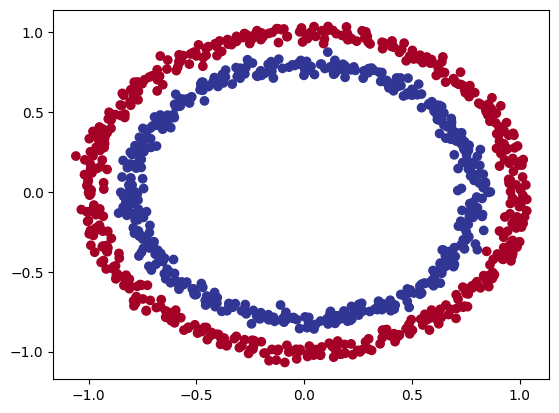

In [38]:
# Visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [31]:
X.shape, y.shape

((1000, 2), (1000,))

In [39]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test split

In [41]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [44]:
# Split data into training and tests sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 20% will be test
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [45]:
# import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass(or forward computation of the model)
4. Instantiate an instance of our model class and send it to the target `device`

In [46]:
# 1. Constuct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [83]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2234, -0.5156],
                      [ 0.4940,  0.2059],
                      [ 0.2639,  0.2894],
                      [ 0.5671,  0.1366],
                      [ 0.5824,  0.6205]])),
             ('0.bias', tensor([-0.0734,  0.6435, -0.4381,  0.2982,  0.1833])),
             ('1.weight',
              tensor([[ 0.1811, -0.0548, -0.0836,  0.2779,  0.0269]])),
             ('1.bias', tensor([0.0577]))])

In [59]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 lables:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.0515],
        [0.0636],
        [0.0981],
        [0.0380],
        [0.2224],
        [0.2288],
        [0.1644],
        [0.2034],
        [0.0928],
        [0.0658]])

First 10 lables:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

For example, for regression you might want MAE or MSE.

For classification you might want binary cross entropy or categorical cross entropy

As a reminder, the loss function measures how *wrong* your models predictions are

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [86]:
# Setup the loss function
loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [61]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (back propagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**. 

We can convert these **logits** into **prediction probabilites** by passing them to some kind of activation function (e.g. sigmoid for binary cross entropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction lables** by either rounding them or taking the `argmax()`.

In [63]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0515],
        [0.0636],
        [0.0981],
        [0.0380],
        [0.2224]])

In [64]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5129],
        [0.5159],
        [0.5245],
        [0.5095],
        [0.5554]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [65]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### 3.2 Building a training and test loop

In [72]:
# I will attemp this on my own and see how I compare to the video

epochs = 500
device = 'cpu'

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train.to(device))
    y_pred_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_pred_probs)

    loss = loss_fn(y_preds.squeeze(), y_train.squeeze())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Start testing
    model_0.eval()
    with torch.inference_mode():
        test_y_logits = model_0(X_test)
        test_y_pred_probs = torch.sigmoid(test_y_logits)
        test_preds = torch.round(test_y_pred_probs)

        test_loss = loss_fn(test_preds.squeeze(), y_test.squeeze())

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Test Loss: {test_loss:.2f}")
    
    

Epoch: 0 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 50 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 100 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 150 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 200 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 250 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 300 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 350 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 400 | Train Loss: 0.81 | Test Loss: 0.81
Epoch: 450 | Train Loss: 0.81 | Test Loss: 0.81


In [87]:
# This is the video version
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000
device = 'cpu'
# Put data to target device. I'm using cpu so this is irrelevant
X_train, y_train = X_train.to(device), y_train.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # This is what I did for my own version

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits
        # The loss function I am using is BCEWithLogitsLoss().
        # That means loss_fn expects logits as an input
        # That's what I probably had wrong in my own version
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69569, Acc: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 100 | Loss: 0.69302, Acc: 50.50% | Test loss: 0.69542, Test acc: 46.50%
Epoch: 200 | Loss: 0.69299, Acc: 51.50% | Test loss: 0.69503, Test acc: 46.50%
Epoch: 300 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69485, Test acc: 45.50%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69476, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Acc: 51.38% | Test loss: 0.69472, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69470, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69469, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69468, Test acc: 46.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [77]:
%pip install requests
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_function.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)

   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   -------- ------------------------------- 1/5 [idna]
   -------- ------------------------------- 1/5 [idna]
   -------- ------------------------------- 1/5 [idna]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   ---------------- ----------------------- 2/5 [char

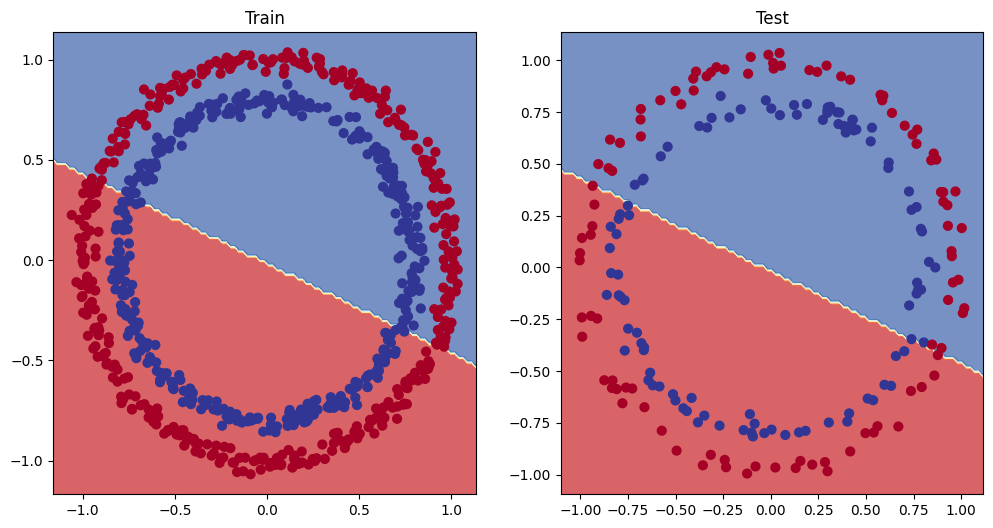

In [88]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data

And because these options aer all values we can change, they are referred to as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations is faster

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
epochs = 1000
device = 'cpu'

model_1 = CircleModelV1()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train.to(device))
    y_pred_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_pred_probs)

    loss = loss_fn(y_logits.squeeze(), y_train.squeeze())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Start testing
    model_1.eval()
    with torch.inference_mode():
        test_y_logits = model_1(X_test)
        test_y_pred_probs = torch.sigmoid(test_y_logits)
        test_preds = torch.round(test_y_pred_probs)

        test_loss = loss_fn(test_y_logits.squeeze(), y_test.squeeze())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Test Loss: {test_loss:.2f}")
    
    

Epoch: 0 | Train Loss: 0.70 | Test Loss: 0.74
Epoch: 100 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 200 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 300 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 400 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 500 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 600 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 700 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 800 | Train Loss: 0.69 | Test Loss: 0.69
Epoch: 900 | Train Loss: 0.69 | Test Loss: 0.69


### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test on a smaller problem

In [94]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [96]:
# Create training and test splits
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

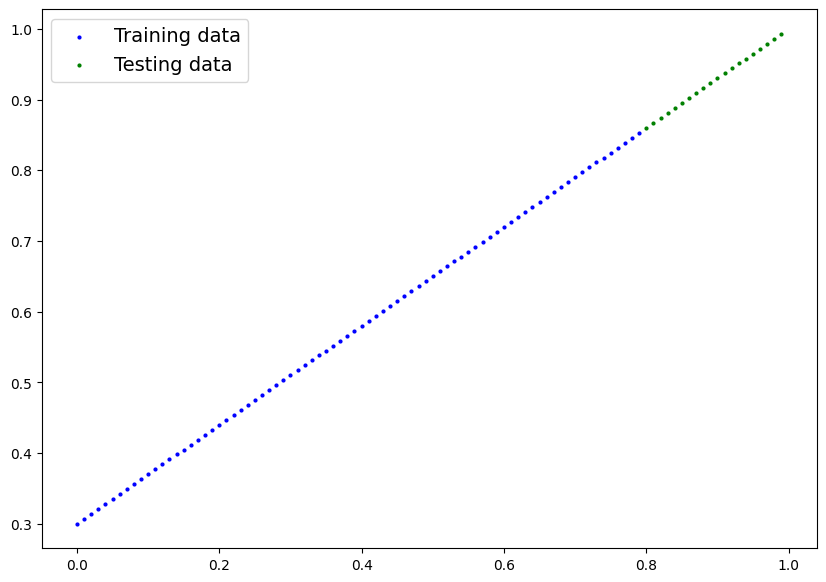

In [97]:
from helper_functions import *
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [108]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

# Train the model
epochs = 1001

for epoch in range(epochs):
    model_2.train()
    y_preds = model_2(X_train_regression)
    loss = loss_fn(y_preds, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)

        test_loss = loss_fn(test_preds, y_test_regression)

    if epoch % 250 == 0:
        print(f"| Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f} |")

| Epoch: 0 | Loss: 0.34857 | Test Loss: 0.59728 |
| Epoch: 250 | Loss: 0.02046 | Test Loss: 0.06721 |
| Epoch: 500 | Loss: 0.01960 | Test Loss: 0.06204 |
| Epoch: 750 | Loss: 0.01824 | Test Loss: 0.05697 |
| Epoch: 1000 | Loss: 0.01603 | Test Loss: 0.05257 |
